# TP IMA207: hyperspectrum images

*Anthor: Benjamin Ternot*

In [1]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
import scipy.fftpack as sff

**I - Data generation and manipulation**

The objective of this first short part is to create some datasets to get accustomed to them. It will enable us to :
- recall the notion of sparsity ;
- geometrically understand the effect of the mixing.

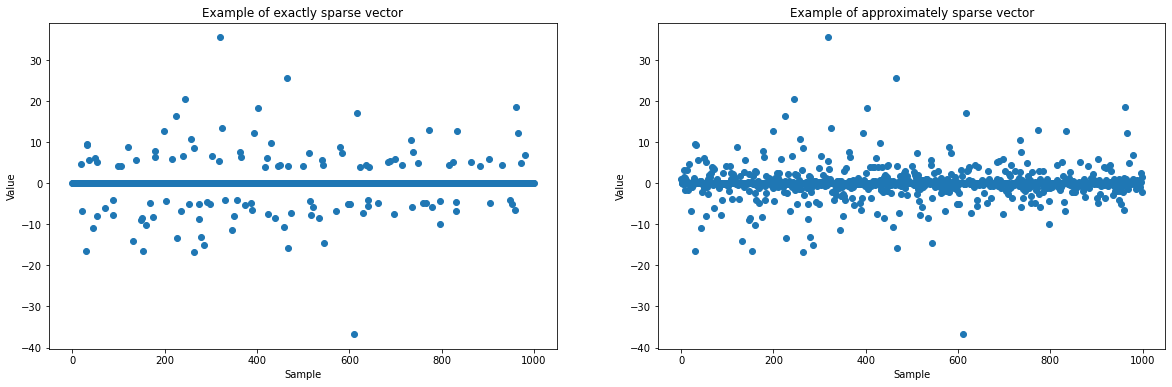

In [2]:
power = 3
approx_sparse = np.random.randn(1000)**power
exact_sparse = approx_sparse*(np.abs(approx_sparse)>4)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.plot(exact_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of exactly sparse vector');

fig.add_subplot(1,2,2)
plt.plot(approx_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of approximately sparse vector');

What is the difference between an exactly and an approximately sparse signal? Recall the two corresponding definitions.

**Answers**  
An exactly sparse signal refers to a signal that has a low-cardinality support compared to the number of samples. This means that a significant number of samples in the signal are exactly zero.  
On the other hand, an approximately sparse signal allows for some flexibility in defining what is considered a zero sample. In other words, it allows for a margin of error when determining zero samples.

Now let's start to look at some mixtures and to try to geometrically interpret the impact of the mixing.

First, generate a simulated source S matrix. Plot the corresponding scatter plot. Interpret the shape of the scatter plot you obtain.

**Answers**  
We obtain a star-shaped figure. This is because the sources are sparse, and we have a significant number of values near (0,0). The branches of the star correspond to values of the form (0,x) and (y,0) for the same reason.

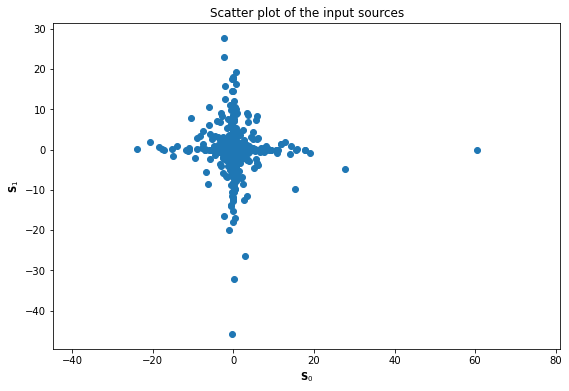

In [3]:
n = 2         # number of sources
t = 1024      # number of samples
noise_level = 80 # noise level, in dB
power = 3 # power exponent used in the source generation



# TO DO : generate a simulated source S matrix. 
# S will be of dimensions n x t.
# Each of the n sources (i.e. lines of S) will follow the approximately sparse 
# law we used above.
S = S = np.random.randn(n, t) ** power  # TO CHANGE

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

In [4]:
# Here, we generate a mixture matrix (dimensions m x t) from the sources in S  
m = 4         # number of observations

A = np.random.randn(m,n)
X = A@S

noise_level = 50

# To be more realistic, we add some noise to the mixing. 
# Mixtures with SNR > 120 dB can be considered as noiseless for most applications.
if noise_level < 120: 
    #--- Add noise
    N = np.random.randn(m,t)
    N = 10.**(-noise_level/20.)*np.linalg.norm(X)/np.linalg.norm(N)*N
    X = X + N

Plot the scatter plot of X. What do you see ? 

What do the directions of the lines you observe correspond ?

Try several A matrices, noise_values and powers. Any comment?

**Answers**  
The directions of the arrows correspond to the first two principal axes given by the mixing matrix. As the power increases, the signals become sparser, and the influence of noise becomes less significant. Additionally, as the noise level increases, the signals become less sparse, and the mixing process blurs the data. The star-shaped structure is lost.

When trying different A matrices, noise values, and powers, it's observed that higher powers lead to sparser signals and reduce the impact of noise. Higher noise levels, on the other hand, make the signals less sparse, resulting in a loss of the star-like structure in the scatter plot.

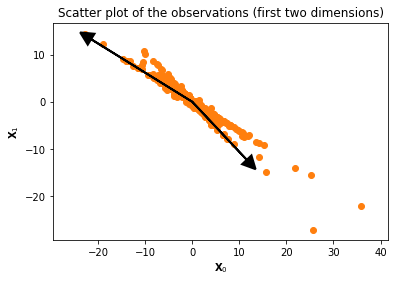

In [5]:
plt.title('Scatter plot of the observations (first two dimensions)')
vrange = 0.25*max(np.sqrt(np.sum(X*X, 0)))
plt.arrow( 0, 0, vrange*A[0, 0], vrange*A[1, 0], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.arrow( 0, 0, vrange*A[0, 1], vrange*A[1, 1], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.plot(X[0,:], X[1,:], 'C1o', zorder=0)
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis('equal');

**II - Performing non-blind source separation**

**1) Data generation**

Before going into blind source separation, in which we want to find physical **A** and **S** matrices such that **X = AS + N**, let us first consider the simpler setting in which we know **A** and want to recover **S**.
We will consider the noisy mixture of two sine signals. The methodology extends to more complex datasets.

N.B. : unmixing two sinus signal could be done much more easily than using the algorithms we saw during the class. Nevertheless, focusing on such synthetic data enables an easy visualization. The principle readily extend to more complex datasets, such as images.

(-25.0, 25.0)

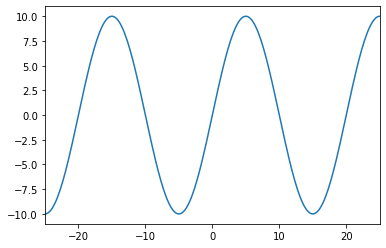

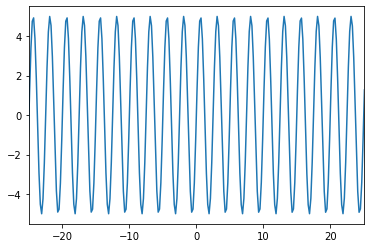

In [6]:
# Source generation
t = 10000
x_abs = np.linspace(-1000,1000,t)

S = np.zeros((2,t))
S[0,:] = 10*np.sin(2*np.pi*0.05*x_abs)
S[1,:] = 5*np.sin(2*np.pi*0.4*x_abs)

plt.figure(),plt.plot(x_abs,S[0,:])
plt.xlim([-25,25])
plt.figure(),plt.plot(x_abs,S[1,:])
plt.xlim([-25,25])

Here, we will transform the sources signals S into the DCT domain.

What is the objective of using the DCT?

Plot the above DCT and justify what you see. Pay attention to the labeling of the x-axis. Try with sines of various frequencies.

**Answers**  

The objective of using the discrete cosine transform (DCT) is to express a finite sequence of data points in terms of a sum of cosine functions oscillating at different frequencies. By transforming the source signals into the DCT domain, we can analyze and manipulate the signals based on their frequency components.

(<Figure size 432x288 with 1 Axes>,
 [<matplotlib.lines.Line2D at 0x18674ebddf0>])

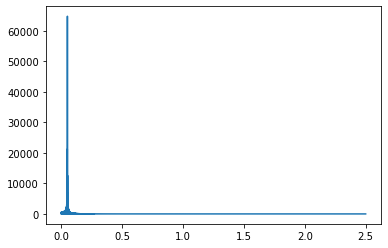

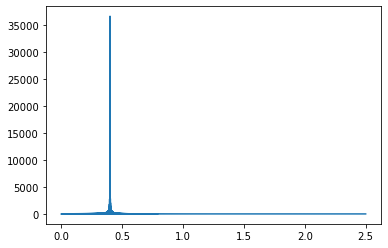

In [7]:
# Transformation into the DCT domain
Sf = sff.dct(S)
plt.figure(), plt.plot(np.linspace(0,2.5,t),np.absolute(Sf[0]))
plt.figure(), plt.plot(np.linspace(0,2.5,t),np.absolute(Sf[1]))

Data generation : now, we will create a mixture X = AS + N.

Plot the mixtures. Explain what you see.

Compute the DCT of X. Plot it and explain. Which caracteristic of the DCT will we use to recover the sources?

**Answers**  

When plotting the DCT, we observe that each sinusoidal signal with a different frequency has a distinct peak in the graph. This indicates that the DCT representation highlights the frequency content of the signals. Consequently, when we mix the signals and later apply the inverse DCT, we can separate and differentiate the individual frequency components by leveraging the reversibility property of the DCT.

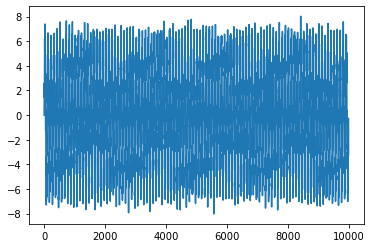

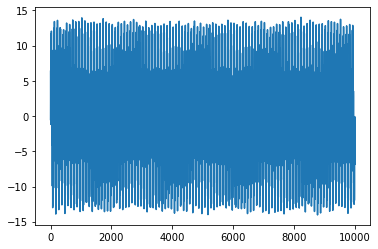

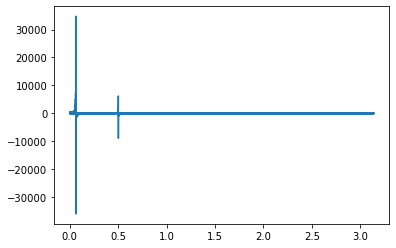

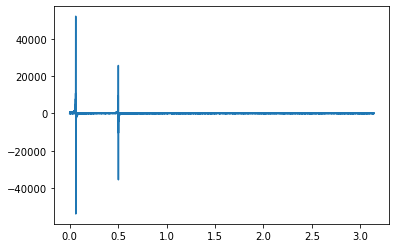

In [8]:
A = np.array([[0.5547002 , 0.24253563],
       [0.83205029, 0.9701425 ]]) # You can try other A values, but the columns must have a unitary norm.

X = A@S
X = X + 0.5*np.random.randn(np.shape(X)[0],np.shape(X)[1])# You can try other noise values

plt.plot(X[0,:])
plt.show()
plt.plot(X[1,:])
plt.show()
Xf = sff.dct(X)
k = np.linspace(0, t - 1, t)
x = np.pi / t * k
plt.plot(x, (Xf[0, : ]))
plt.show()
plt.plot(x, (Xf[1, : ]))
plt.show()

**2) Source separation**

Now that we generated observations from simulated sources, we will focus on the source separation problem: recovering the sources from the observations (and the knowledge of A, since we are here in the non-blind setting).

To do that, we propose here to solve the source separation problem using a sparsity constraint on the sources. The cost function will then be minimized using the ISTA algorithm.

First, write the cost function we want to minimize to perform non-blind sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?


**Answers**  
The cost function is given by the expression:
$$argmin_{A \in \mathbb{R}^{m \times n},S \in \mathbb{R}^{n \times t}}\frac{1}{2}||X-AS||^2_F +\lambda||S||_1$$
where:

* $\frac{1}{2}||X-AS||^2_F$ represents the data-fidelity term, which measures the closeness of the reconstructed signal to the observed mixture signal X. It is a smooth term.

* $\lambda||S||_1$ represents the sparsity term, which promotes sparsity in the source signal matrix S. It encourages many entries of S to be exactly zero, facilitating the separation of individual sources. This term is not smooth due to the use of the $||.||_1$ norm.

The cost function is convex because the data-fidelity term is quadratic and the sparsity term is convex. However, it is important to note that the convexity holds when A is fixed and S is being optimized.

Compute the gradient along the S variable of the data-fidelity term.

Recall what the proximal operator of the l1-norm is.

**Answer**  
The proximal operator of the L1-norm, also known as the soft-thresholding operator, is defined as follows:
$$(prox_{\lambda |.||_1}(v))_i = S_{\lambda}(v) =  \begin{cases} 
      v_i-\lambda &, v_i \ge \lambda \\
      0 &, |v_i|\leq \lambda \\
      v_i+\lambda &, v_i \le -\lambda
\end{cases}$$
In simpler terms, the soft-thresholding operator applies a shrinkage operation to each element of the input vector v. If the element is greater than or equal to the threshold $\lambda$, it is reduced by $\lambda$. If the absolute value of the element is less than or equal to the threshold, it is set to zero. If the element is smaller than or equal to the negative threshold $-\lambda$, it is increased by $\lambda$.

In [9]:
# TO DO: implement the proximal operator of the l1-norm in the above function:
def prox_l1(S_est,thrd):
    S_est = np.sign(S_est) * np.maximum(np.abs(S_est) - thrd, 0)
    return S_est


Explain the main idea of the ISTA algorithm. Then, implement it.

**Answer**  
The main idea of the Iterative Soft Thresholding Algorithm (ISTA) is to minimize the cost function by performing a gradient descent on the data-fidelity term and then promoting sparsity through additional minimization steps.

In [10]:
# TO DO: implement the ISTA algorithm to minimize the cost function you wrote in question II-2-1.
def ISTA(X, A=np.eye(2), n=2, lamb=0, nbIt=100):
    S_est = np.zeros((A.shape[1], X.shape[1]))
    gamma = 0.9 / np.linalg.norm(A.T @ A)
    for _ in range(nbIt):
        gradient = A.T @ (A @ S_est - X)
        S_est = np.sign(S_est - gamma * gradient) * np.maximum(np.abs(S_est - gamma * gradient) - lamb, 0)
    return S_est

It's now time to play with the code : launch the ISTA algorithm and look at the results.

Try various lamb values. What is the minimum value you should no go below? What is the issue with choosing too big values?

**Answer**  
Choosing a $\lambda$ equal to or less than $0$ will not yield sparse results, so we need to ensure that $\lambda > 0$.

On the other hand, selecting $\lambda$ values that are too large can lead to excessive regularization, causing a loss of important signal information. As $\lambda$ increases, more signals will be suppressed and pushed closer to zero, potentially distorting or completely eliminating meaningful components of the original sources.

In [11]:
S_estf = ISTA(Xf,A = A,n=2,lamb=1000,nbIt = 1000)

Plot the estimated sources in the DCT domain. What kind of sparsity to they exhibit? Why?

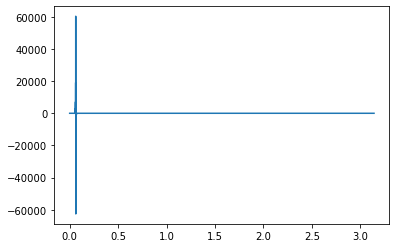

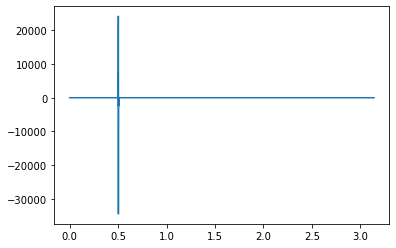

In [12]:
plt.plot(x, S_estf[0, : ])
plt.show()
plt.plot(x, S_estf[1, : ])
plt.show()

Transform the sources back in the direct domain. Plot them. What do you see? Explain the differences with the original sources. Conclude.

**Answer**  
The use of the DCT in transforming the sources allows for the recovery of the original signal to a large extent. However, the reconstruction quality may vary at the edges, and we should be carefull to potential scaling factors.

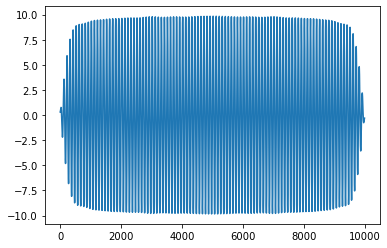

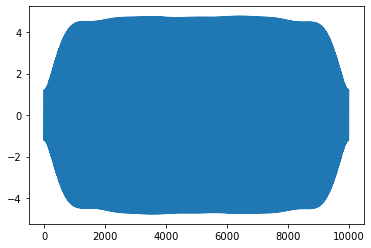

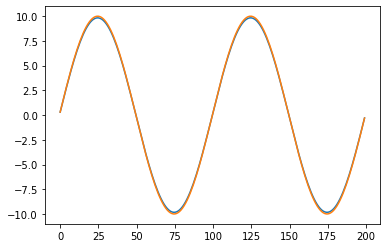

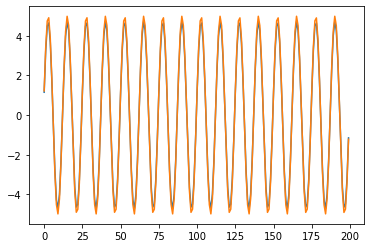

In [13]:
S_tdomain = sff.idct(S_estf) / 20000

plt.plot(S_tdomain[0, :])
plt.show()

plt.plot(S_tdomain[1, :])
plt.show()

# Compare the central parts of the original and estimated sources.
center = 100

plt.plot(S_tdomain[0, 5000 - center:5000 + center])
plt.plot(S[0, 5000 - center:5000 + center])
plt.show()

plt.plot(S_tdomain[1, 5000 - center:5000 + center])
plt.plot(S[1, 5000 - center:5000 + center])
plt.show()

**III - Blind Source Separation : PALM**

Let's now delve into the core problem : *blind* source separation, in which **A** is unknown. To leverage sparsity, we will use the PALM algorithm.

Thoughout this whole section, we will re-use the same synthetic data as above (i.e., the one generated in II-1).

Write the cost function we want to minimize to perform *blind* sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?




**Answers**  
The cost function for blind sparse source separation is given by:

$$argmin_{A \in \mathbb{R}^{m \times n},S \in \mathbb{R}^{n \times t}}\frac{1}{2}||X-AS||^2_F +\lambda||S||_1+\iota_{\{\forall i \in [1,n];||a_{:,j}||^2_{l_2}\le1\}}(A)$$

Where:
* $\frac{1}{2}||X - AS||_F^2$ represents the data-fidelity term, which measures the difference between the reconstructed signal $AS$ and the observed signal $X$. This term is smooth.

* $\lambda||S||_1$ promotes sparsity in the source matrix $S$. The $||S||_1$ term encourages a large number of zero or near-zero entries in $S$, facilitating source separation. This term is non-smooth due to the L1-norm.

* $\iota_{{\forall i \in [1,n];||a_{:,j}||_2^2\leq1}}(A)$ is the oblique constraint term, which imposes constraints on the columns of the mixing matrix $A$. It ensures that each column of $A$ has a Euclidean norm less than or equal to 1. This term enforces the assumption that the mixing process does not introduce amplification or scaling effects. It is typically non-smooth.

Regarding the convexity of the cost function, the combination of the L1-norm and the oblique constraint makes the cost function non-convex in this form.

Recall what the gradient of the data fidelity term over A is.

**Answer**  
Gradient along the S variable:
$$\nabla f(S^{(k)}) = A^T(AS-X)$$

Compte the proximal operator of the oblique constraint. Implement it.

In [14]:
def prox_oblique(A):
    for j in range(A.shape[1]):
        A[:, j] = A[ : , j] / max(1, np.linalg.norm(A[ : , j]))    
    return A

Implement the PALM algorithm to minimize the cost function you wrote in III-1).

In [15]:
def PALM(X, n=2, lamb=0, nbIt=100):
    S_est = np.zeros((n, X.shape[1]))
    A_est = np.eye(X.shape[0], n)

    for i in range(nbIt):
        grad_S = np.dot(A_est.T, (X - np.dot(A_est, S_est)))
        S_est = prox_l1(S_est + (0.9 / (np.linalg.norm(A_est.T @ A_est) + 1e-16)) * grad_S, lamb)

        grad_A = np.dot((X - np.dot(A_est, S_est)), S_est.T)
        A_est = prox_oblique(A_est + (0.9 / (np.linalg.norm(S_est @ S_est.T) + 1e-16)) * grad_A)

    return A_est, S_est

Launch the PALM algorithm to retrieve both A and S from X. Plot your results. How good is the separation? The separation quality is usually well evaluated comparing the true and estimated A matrices.

**Answers**  
The results obtained from the PALM algorithm indicate a good separation quality. By visually inspecting the graph, we can observe that the reconstructed sinusoidal signals closely resemble the original signals, suggesting a successful separation.

To further evaluate the separation quality, we can compare the true and estimated mixing matrices (A matrices). Comparing their values, we find a high degree of similarity, with matching values up to the third decimal place. This close correspondence between the true and estimated A matrices indicates a successful retrieval of the mixing process.

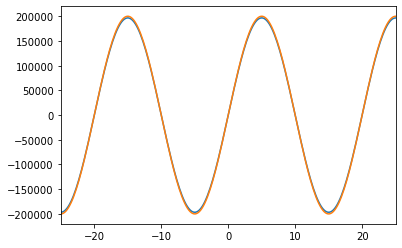

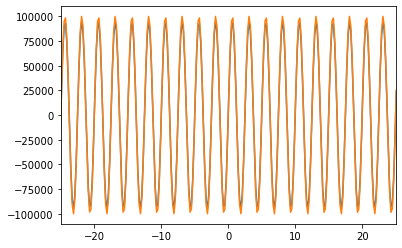

A:
[[0.5547002  0.24253563]
 [0.83205029 0.9701425 ]]
A_est:
[[0.55537211 0.24063259]
 [0.83160196 0.97061628]]


In [16]:
A_fest, S_fest = PALM(Xf, n=2, lamb=1000, nbIt=1000)

S_tdomain = sff.idct(S_fest)

plt.figure()
plt.plot(x_abs, S_tdomain[0])
plt.plot(x_abs, 200000 * np.sin(2 * np.pi * 0.05 * x_abs))
plt.xlim([-25, 25])

plt.figure()
plt.plot(x_abs, S_tdomain[1])
plt.plot(x_abs, 100000 * np.sin(2 * np.pi * 0.4 * x_abs))
plt.xlim([-25, 25])
plt.show()

print(f'A:\n{A}')
print(f'A_est:\n{A_fest}')